# Notebook Imports

In [1]:
import os, sys

from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer as pt
from nltk.stem import SnowballStemmer as ss
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as wt

from bs4 import BeautifulSoup as bs
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split as ttsplit
from sklearn.linear_model import LinearRegression as lr


%matplotlib inline
%config IPCompleter.greedy=True

# Constants

In [153]:
REL_PATH = 'static\\SpamData\\01_Processing\\practice_email.txt'
file_dir = os.path.dirname(os.path.realpath('__file__'))

print(file_dir)
EXAMPLE_FILE = os.path.join(file_dir, REL_PATH)

#SPAM_1_PATH = os.path.join(file_dir,'static\\SpamData\\01_Processing\\spam_assassin_corpus\\spam_1')
SPAM_1_PATH = 'static\\SpamData\\01_Processing\\spam_assassin_corpus\\spam_1'
SPAM_2_PATH = os.path.join(file_dir,'static\\SpamData\\01_Processing\\spam_assassin_corpus\\spam_2')
EASY_NONSPAM_1_PATH = os.path.join(file_dir,'static\\SpamData\\01_Processing\\spam_assassin_corpus\\easy_ham_1')
EASY_NONSPAM_2_PATH = os.path.join(file_dir,'static\\SpamData\\01_Processing\\spam_assassin_corpus\\easy_ham_2')

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500               # V reálnom svete by to malo byť prvých 5 - 15 tis. najčastejších slov

DATA_JSON_FILE = 'static\\SpamData\\01_Processing\\email-text-data.json'
WORD_ID_FILE = 'static\\SpamData\\01_Processing\\word-by-id.csv'

TRAINING_DATA_FILE = 'static\\SpamData\\02_Training\\train-data.txt'
TEST_DATA_FILE = 'static\\SpamData\\02_Training\\test-data.txt'

WHALE_FILE = 'static\\SpamData\\01_Processing\\wordcloud_resources\\whale-icon.png'
SKULL_FILE = 'static\\SpamData\\01_Processing\\wordcloud_resources\\skull-icon.png'
THUMBS_UP_FILE = 'static\\SpamData\\01_Processing\\wordcloud_resources\\thumbs-up.png'
THUMBS_DOWN_FILE = 'static\\SpamData\\01_Processing\\wordcloud_resources\\thumbs-down.png'
FONT_BOLD_FILE = 'static\\SpamData\\01_Processing\\wordcloud_resources\\OpenSansCondensed-Bold.ttf'
FONT_LIGHT_FILE = 'static\\SpamData\\01_Processing\\wordcloud_resources\\OpenSansCondensed-Light.ttf'

F:\GITHUB\2022 Datascience and ML Bootcamp


# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()
print(type(message))
print(message)
sys.getfilesystemencoding()

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

'utf-8'

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':           # Kontrolujeme načítanie prázdneho riadka, ktorý je po konci hlavicky
        is_body = True

stream.close()

email_body = '\n'.join(lines)

print(email_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

Funkcie, ktoré vracajú viacero hodnôt naraz

In [5]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [6]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

# Email body extraction

In [7]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            file_path = join(root, file_name)
            stream = open(file_path, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)

            yield file_name, email_body

In [8]:
def df_from_directory (path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

In [9]:
spam_emails = pd.concat([df_from_directory(SPAM_1_PATH, SPAM_CAT), df_from_directory(SPAM_2_PATH, SPAM_CAT)])
spam_emails.shape


(1898, 2)

In [10]:
spam_emails

CATEGORY  \
00001.7848dde101aa985090474a91ec93fcf0         1   
00002.d94f1b97e48ed3b553b3508d116e6a09         1   
00003.2ee33bc6eacdb11f38d052c44819ba6c         1   
00004.eac8de8d759b7e74154f142194282724         1   
00005.57696a39d7d84318ce497886896bf90d         1   
...                                          ...   
01397.f75f0dd0dd923faefa3e9cc5ecb8c906         1   
01398.8ca7045aae4184d56e8509dc5ad6d979         1   
01399.2319643317e2c5193d574e40a71809c2         1   
01400.b444b69845db2fa0a4693ca04e6ac5c5         1   
cmds                                           1   

                                                                                  MESSAGE  
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...  
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00004.eac8de8d759b7e74154f142194282724  ##############################################...  
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...  
...                                                                                   ...  
01397.f75f0dd0dd923faefa3e9cc5ecb8c906  This is a multi-part message in MIME format.\n...  
01398.8ca7045aae4184d56e8509dc5ad6d979  Dear Subscriber,\n\n\n\nIf I could show you a ...  
01399.2319643317e2c5193d574e40a71809c2  ****Mid-Summer Customer Appreciation SALE!****...  
01400.b444b69845db2fa0a4693ca04e6ac5c5  ATTN:SIR/MADAN      \n\n\n\n                  ...  
cmds                                                                                       

[1898 rows x 2 columns]

In [11]:
ham_emails = pd.concat([df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT), df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)])

ham_emails.shape

(3901, 2)

In [12]:
ham_emails

CATEGORY  \
00001.7c53336b37003a9286aba55d2945844c         0   
00002.9c4069e25e1ef370c078db7ee85ff9ac         0   
00003.860e3c3cee1b42ead714c5c874fe25f7         0   
00004.864220c5b6930b209cc287c361c99af1         0   
00005.bf27cdeaf0b8c4647ecd61b1d09da613         0   
...                                          ...   
01396.61983fbe6ec43f55fd44e30fce24ffa6         0   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0   
01398.169b51731fe569f42169ae8f948ec676         0   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0   
01400.f897f0931e461e7b2e964d28e927c35e         0   

                                                                                  MESSAGE  
00001.7c53336b37003a9286aba55d2945844c      Date:        Wed, 21 Aug 2002 10:54:46 -05...  
00002.9c4069e25e1ef370c078db7ee85ff9ac  Martin A posted:\n\nTassos Papadopoulos, the G...  
00003.860e3c3cee1b42ead714c5c874fe25f7  Man Threatens Explosion In Moscow \n\n\n\nThur...  
00004.864220c5b6930b209cc287c361c99af1  Klez: The Virus That Won't Die\n\n \n\nAlready...  
00005.bf27cdeaf0b8c4647ecd61b1d09da613  >  in adding cream to spaghetti carbonara, whi...  
...                                                                                   ...  
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...  
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...  
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...  

[3901 rows x 2 columns]

In [13]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data

Shape of entire dataframe is  (5799, 2)


CATEGORY  \
00001.7848dde101aa985090474a91ec93fcf0         1   
00002.d94f1b97e48ed3b553b3508d116e6a09         1   
00003.2ee33bc6eacdb11f38d052c44819ba6c         1   
00004.eac8de8d759b7e74154f142194282724         1   
00005.57696a39d7d84318ce497886896bf90d         1   
...                                          ...   
01396.61983fbe6ec43f55fd44e30fce24ffa6         0   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0   
01398.169b51731fe569f42169ae8f948ec676         0   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0   
01400.f897f0931e461e7b2e964d28e927c35e         0   

                                                                                  MESSAGE  
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...  
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00004.eac8de8d759b7e74154f142194282724  ##############################################...  
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...  
...                                                                                   ...  
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...  
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...  
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...  

[5799 rows x 2 columns]

# Data Cleaning: Checking for Missing Values

In [14]:
# Check if any message bodies are null

#data.MESSAGE

# Toto vráti True ak je null, False ak nie
data['MESSAGE'].isnull().values.any()

False

In [15]:
type("")

str

In [16]:
len("")

0

In [17]:
my_var = None

In [18]:
type(my_var)

NoneType

In [19]:
# Check if there are empty emails (string lenght 0)
(data.MESSAGE.str.len() == 0).any()

True

In [20]:
(data.MESSAGE.str.len() == 0).sum()

3

In [21]:
# Challenge: how to checkthe number of entries with null/none values?
data['MESSAGE'].isnull().sum()

0

### Locate empty emails

In [22]:
type((data.MESSAGE.str.len() == 0))

pandas.core.series.Series

In [23]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [24]:
data.index.get_loc('cmds')


array([False, False, False, ..., False, False, False])

In [25]:
data[4608:4611]

CATEGORY  \
00210.ca401834d76bbedb98e548160e2ab559         0   
00211.835ec23b746b6aede4e2e15ced421bb4         0   
00212.df5211161d938a2547804a50f0a8698f         0   

                                                                                  MESSAGE  
00210.ca401834d76bbedb98e548160e2ab559  I have a strange problem with one user in a sm...  
00211.835ec23b746b6aede4e2e15ced421bb4  I just heard from Kevin Patrick Scannell, auth...  
00212.df5211161d938a2547804a50f0a8698f  At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...

# Remove System File Entries from Dataframe

In [26]:
data.drop(['cmds'], inplace=True)   # upravi DF ako je, netreba ju prepisovať
#data = data.drop(['cmds'])

In [27]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [28]:
document_ids = range(0,len(data.index))
data['DOC_ID'] = document_ids
print(len(data.index))
print(data['DOC_ID'])

5796
00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64


In [29]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
0              1  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
1              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
2              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
3              1  ##############################################...   
4              1  I thought you might like these:\n\n1) Slim Dow...   
...          ...                                                ...   
5791           0  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
5792           0  > >-- be careful when using this one.) Also, t...   
5793           0  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
5794           0  So then, "Mark Hammond" <mhammond@skippinet.co...   
5795           0  Hi there,\n\n\n\nNow this is probably of no us...   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d  
...                                        ...  
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e  

[5796 rows x 3 columns]

# Save to File using Pandas

In [30]:
data.to_json(DATA_JSON_FILE)

# Number of SPAM Messages Visualised (Pie Charts)

In [31]:
data.CATEGORY.value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [32]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

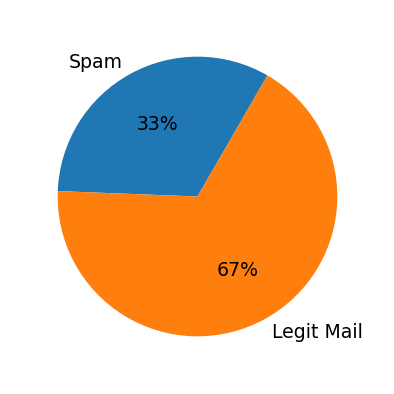

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=60, autopct='%1.0f%%')
plt.show()

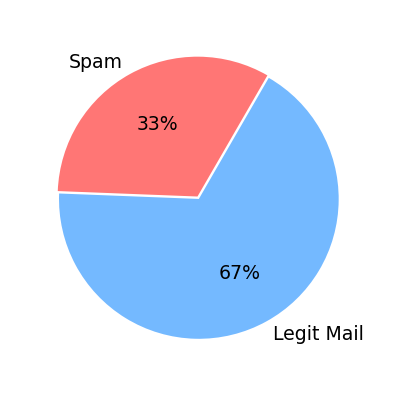

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']



plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=60, autopct='%1.0f%%',
       colors=custom_colours, explode=[0, 0.02])
plt.show()

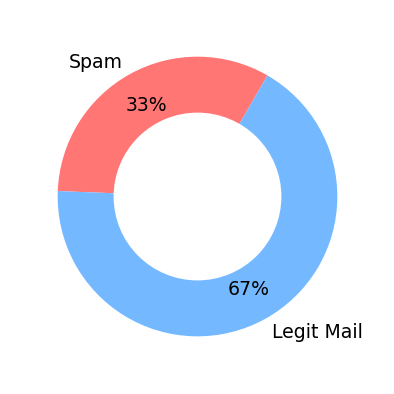

In [35]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=60, autopct='%1.0f%%',
       colors=custom_colours, pctdistance=0.75)

# Draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

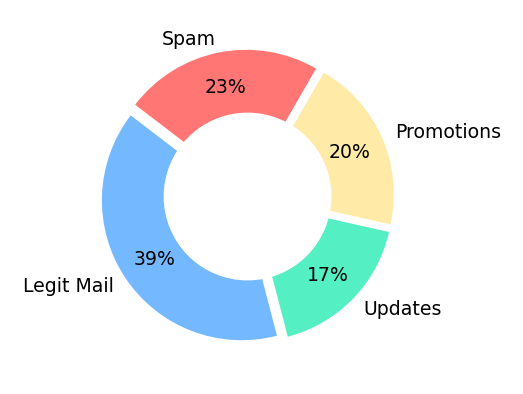

In [36]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25,43,19,22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=60, autopct='%1.0f%%',
       colors=custom_colours, pctdistance=0.75, explode=offset)

# Draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing
- Converting to lower case
- Tokenising
- Removing stop words
- Stripping out html Tags
- Word stemming - konverzia individuálnych slov na ich koreň 
- remove punctuation



In [37]:
# convert to lower case
msg = 'All work an no play makes Jack a dully boy.'
msg.lower()

'all work an no play makes jack a dully boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eavf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eavf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\eavf\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\eavf\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenising

In [41]:
msg = 'All work an no play makes Jack a dully boy.'
# word_tokenize = wt
wt(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dully', 'boy', '.']

## Remowing Stopwords

In [42]:
print(type(stopwords.words('english')))
print(stopwords.words('english'))

<class 'list'>
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 

In [43]:
# So, convert to set - lepšie na hľadanie
stop_words = set(stopwords.words('english'))

# Check for membership
if 'this' in stop_words: print('Found it!')

Found it!


In [44]:
if 'Hallo' not in stop_words: print('Nope. Not in here it!')

Nope. Not in here it!


In [45]:
msg = 'All work an no play makes Jack a dully boy. To be or not to be.'
words = wt(msg.lower())

filtered_words = []

# Challenge: append non-stop words to filteres_words

for wrd in words:
    if wrd not in stop_words:
        filtered_words.append(wrd)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dully', 'boy', '.', '.']


## Word Stems and Stemming

Dať slovo do základného tvaru

In [46]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = wt(msg.lower())

# stemmer = pt() - porter stemmer
# stemmer = ss() - SnowballStemmer
stemmer = ss('english')

filtered_words = []

# Challenge: append non-stop words to filteres_words

for wrd in words:
    if wrd not in stop_words:
        stemmed_word = stemmer.stem(wrd)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Remowing Punctuation

In [47]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. ???? \
      Nobody expects the Spanish Inquisition!'
words = wt(msg.lower())
stemmer = ss('english')
filtered_words = []

for wrd in words:
    if wrd not in stop_words and wrd.isalpha():
        stemmed_word = stemmer.stem(wrd)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [48]:
'p?'.isalpha()

False

## Removing HTML tags from Emails

In [49]:
soup = bs(data.at[145,'MESSAGE'], 'html.parser')

#print(soup.prettify())

print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0//EN">
<html>
 <head>
  <title>
   www.low-interest-rates.net
  </title>
  <style>
   <!--

td {

	font-family: Verdana, Tahoma, sans-serif;

	font-size: 12px;

	color: black;

}



text {

	font-family: Verdana, Tahoma, sans-serif;

	font-size: 11px;

	color: black;

}



text2 {

	font-family: Verdana, Tahoma, sans-serif;

	font-size: 12px;

	color: black;

}



header {

	font-family: Trebuchet MS, Verdana, Tahoma, sans-serif;

	font-size: 17px;

	color: white;

}



title {

	font-family: Trebuchet MS, Verdana, Tahoma, sans-serif;

	font-size: 20px;

	color: #D6CFAB;

	font-weight: bold;

}



h4 {

	color: #B5C943;

	font-family: Tahoma, sans-serif;

}



footer {

	font-family: Verdana, Tahoma, sans-serif;

	font-size: 10px;

	color: white;

	font-weight: bold;

}



a.footer {color: white; text-decoration: none;}

a.footer:visited {color: white; text-decoration: none;}

a.footer:hover {color: white; text-decoration: underline;}



butto

In [50]:
soup.get_text()

"\n\n\n\nwww.low-interest-rates.net\n\n\n\n\n\n\n\n\n\n\n\xa0\xa0=\n\n\xa0\xa0\xa0\xa0quotepoolmortgage™\n\n\n\n\n\n\n\nWe're different and it's a difference that can save you time and money.\n\nWe can help you:\n\n•Refinance to get a lower rate\n•Cons=\n\nolidate your high-interest debt\n•Lowe=\n\nr your monthly payments\n•Get =\n\nextra cash for a vacation\n•Pay for=\n\n tuition\n•Start h=\n\nome improvements\n•Purc=\n\nhase a New Home\n\n\nWe understand that there are a lot of decisions to make wh=\n\nen securing a mortgage loan or refinancing your current loan.  That's why =\n\nwe have mortgage EXPERTS with years of EXPERIENCE to help you make the rig=\n\nht decisions.  \n\n\n\nCredit doesn't have to be an issue either.  Whether your c=\n\nredit's perfect or less than perfect, we can help you find the best deal o=\n\nn your home loan. Our quick, FREE, easy form will put you in contact with =\n\nthe top brokers in the business!\nDON'T Miss The Opportunity to SAVE!\nNow is the perfec

## Functions for Email Processing

In [51]:
def clean_message(message, stemmer=pt(), 
                  stop_words=set(stopwords.words('english'))):
    
    # Converts to lower case and splits up the words
    words = wt(message.lower())
    
    
    filtered_words = []
    
    
    for wrd in words:
        # Remowes the stop words and punctuation
        if wrd not in stop_words and wrd.isalpha():
            filtered_words.append(stemmer.stem(wrd))
    
    
    return filtered_words

In [52]:
clean_message(email_body)          # definovane v cell 4

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [53]:
# Challenge: Modify function to remove HTML Tags

def clean_message_no_html(message, stemmer=pt(), 
                  stop_words=set(stopwords.words('english'))):
    
    # Remove HTML Tags
    soup = bs(message, 'html.parser')
    
    # Converts to lower case and splits up the words
    words = wt(soup.get_text().lower())
    
    
    filtered_words = []
    
    
    for wrd in words:
        # Remowes the stop words and punctuation
        if wrd not in stop_words and wrd.isalpha():
            filtered_words.append(stemmer.stem(wrd))
            # filtered_words.append(wrd) - toto je pre worldcloud....
    
    return filtered_words

In [54]:
clean_message_no_html(data.at[145,'MESSAGE'])

['differ',
 'differ',
 'save',
 'time',
 'money',
 'help',
 'get',
 'lower',
 'rate',
 'olid',
 'debt',
 'r',
 'monthli',
 'payment',
 'extra',
 'cash',
 'vacat',
 'tuition',
 'ome',
 'improv',
 'hase',
 'new',
 'home',
 'understand',
 'lot',
 'decis',
 'make',
 'en',
 'secur',
 'mortgag',
 'loan',
 'refinanc',
 'current',
 'loan',
 'mortgag',
 'expert',
 'year',
 'experi',
 'help',
 'make',
 'ht',
 'decis',
 'credit',
 'issu',
 'either',
 'whether',
 'redit',
 'perfect',
 'less',
 'perfect',
 'help',
 'find',
 'best',
 'deal',
 'n',
 'home',
 'loan',
 'quick',
 'free',
 'easi',
 'form',
 'put',
 'contact',
 'top',
 'broker',
 'busi',
 'miss',
 'opportun',
 'save',
 'perfect',
 'time',
 'secur',
 'mortgag',
 'loan',
 'h',
 'countri',
 'recess',
 'feder',
 'govern',
 'keep',
 'lower',
 'st',
 'rate',
 'help',
 'stimul',
 'economi',
 'situat',
 'benefit',
 'mostli',
 'homeown',
 'tri',
 'excus',
 'great',
 'rate',
 'avail',
 'simpl',
 'form',
 'cost',
 'noth',
 'fill',
 'free',
 'proceed

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [55]:
data.iat[145,2]

'00146.e9b64856c0cd982a64f47c9ab9084287'

In [56]:
data.iloc[5:11]

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
5              1  A POWERHOUSE GIFTING PROGRAM You Don't Want To...   
6              1  Help wanted.  We are a 14 year old fortune 500...   
7              1  <html>\n\n<head>\n\n<title>ReliaQuote - Save U...   
8              1  TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...   
9              1  Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...   
10             1  Cellular Phone Accessories All At Below Wholes...   

                                     FILE_NAME  
DOC_ID                                          
5       00006.5ab5620d3d7c6c0db76234556a16f6c1  
6       00007.d8521faf753ff9ee989122f6816f87d7  
7       00008.dfd941deb10f5eed78b1594b131c9266  
8       00009.027bf6e0b0c4ab34db3ce0ea4bf2edab  
9       00010.445affef4c70feec58f9198cfbc22997  
10      00011.61816b9ad167657773a427d890d0468e

In [57]:
data.MESSAGE.iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [58]:
first_emails = data.MESSAGE.iloc[0:3]

# apply function to every message
nested_list = first_emails.apply(clean_message)

In [59]:
# Naplnime list flat_list slovami z prvých mailov
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

# print(flat_list)

321

In [60]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [61]:
%%time

# use apply() on all the messages in the dataframe - vykoná sa funkcia "clean_message_no_html" na kaýdej bunke
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\eavf\AppData\Local\Temp\ipykernel_50876\3159258238.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = bs(message, 'html.parser')
C:\Users\eavf\AppData\Local\Temp\ipykernel_50876\3159258238.py:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = bs(message, 'html.parser')


CPU times: total: 25.6 s
Wall time: 25.7 s


In [62]:
# nested_list je Series, kde sú iba messages a are očistené a bez html
nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

### Using Logic to Slice Dataframes

In [63]:
# data[data.CATEGORY == 1] - vráti iba spam...
data[data.CATEGORY == 1].tail()


CATEGORY                                            MESSAGE  \
DOC_ID                                                                
1891           1  <html>\n\n<head>\n\n<meta http-equiv="content-...   
1892           1  This is a multi-part message in MIME format.\n...   
1893           1  Dear Subscriber,\n\n\n\nIf I could show you a ...   
1894           1  ****Mid-Summer Customer Appreciation SALE!****...   
1895           1  ATTN:SIR/MADAN      \n\n\n\n                  ...   

                                     FILE_NAME  
DOC_ID                                          
1891    01396.e80a10644810bc2ae3c1b58c5fd38dfa  
1892    01397.f75f0dd0dd923faefa3e9cc5ecb8c906  
1893    01398.8ca7045aae4184d56e8509dc5ad6d979  
1894    01399.2319643317e2c5193d574e40a71809c2  
1895    01400.b444b69845db2fa0a4693ca04e6ac5c5

In [64]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which
# hold onto the indices for the spam and the non-spam emails respectively.

doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [65]:
# doc_ids_ham sú iba indexy záznamov kde sú ham emails
doc_ids_ham


Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [66]:
type(doc_ids_ham)

pandas.core.indexes.base.Index

In [67]:
type(nested_list)

pandas.core.series.Series

In [68]:
# Najdeme všetky záznamy HAM v nested_list
nested_list_ham = nested_list.loc[doc_ids_ham]

In [69]:
nested_list_ham.shape

(3900,)

In [70]:
nested_list_ham

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 3900, dtype: object

In [71]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [72]:
# Challenge: use python list comprehension and then find the total number of
# words in our cleaned dataset of spam email bodies. Also find the total number of words
# in normal emails in the dataset. Then find the 10 most common words used in spam.
# Also, find the 10 most common words used in non-spam messages.

# My solution
newdict = {}

for x in nested_list_ham:
    for y in x:
        if y not in newdict:
            newdict[y] = 1
        else:
            newdict[y] = newdict.get(y) + 1

print(dict(sorted(newdict.items(), key=lambda item: item[1], reverse=True)))

{'http': 7563, 'use': 3633, 'list': 2880, 'one': 2373, 'get': 2286, 'mail': 2255, 'would': 2003, 'like': 1931, 'messag': 1849, 'work': 1800, 'time': 1741, 'wrote': 1679, 'file': 1583, 'new': 1500, 'peopl': 1474, 'user': 1439, 'make': 1397, 'linux': 1374, 'group': 1341, 'email': 1277, 'chang': 1230, 'think': 1216, 'system': 1196, 'also': 1177, 'inform': 1150, 'way': 1148, 'could': 1144, 'said': 1118, 'go': 1118, 'say': 1111, 'need': 1082, 'look': 1073, 'know': 1061, 'run': 1058, 'spam': 1057, 'date': 1050, 'want': 1039, 'tri': 1028, 'see': 994, 'problem': 977, 'even': 975, 'thing': 941, 'world': 938, 'year': 908, 'set': 866, 'first': 863, 'url': 862, 'server': 860, 'line': 840, 'instal': 834, 'well': 825, 'good': 806, 'may': 800, 'right': 798, 'version': 783, 'take': 781, 'much': 763, 'maintain': 757, 'still': 749, 'irish': 724, 'mani': 723, 'seem': 707, 'find': 707, 'ilug': 696, 'network': 678, 'subscript': 676, 'someth': 673, 'sinc': 670, 'compani': 670, 'code': 664, 'state': 664, 'un

In [73]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

20815

In [74]:
normal_words[:10]


http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
Name: count, dtype: int64

In [75]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]

13242

In [76]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64

# Creating a Word Cloud

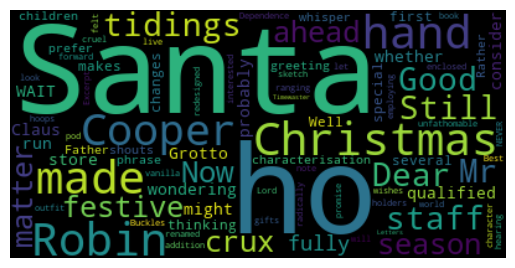

In [77]:
wc = WordCloud().generate(email_body)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [78]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [79]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [80]:
# Ak chceme dostať slová, musíme ich z objektu dostať

word_list = [''.join(word) for word in example_corpus]

novel_as_string = ' '.join(word_list)


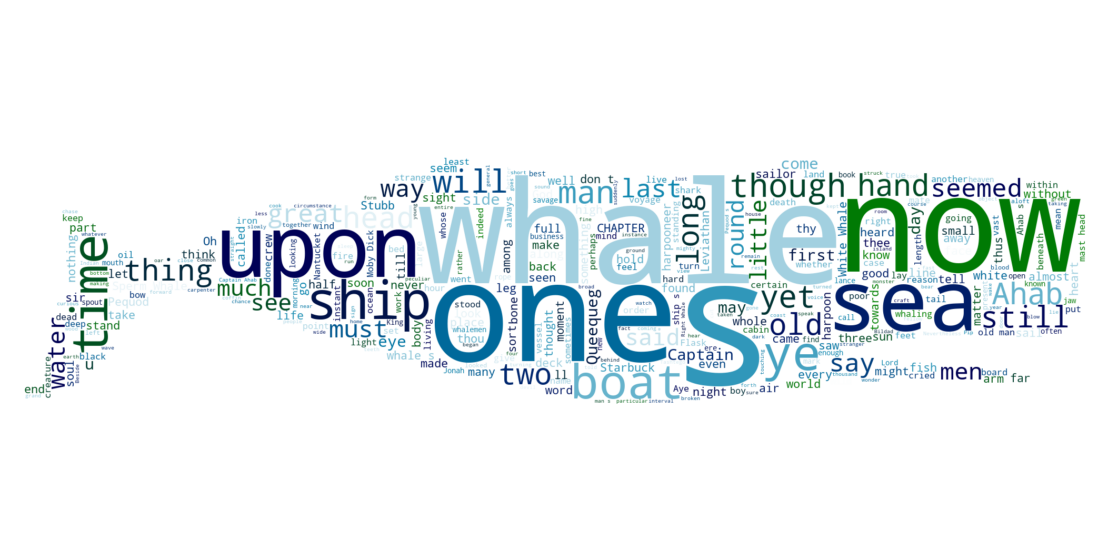

In [81]:
whale_icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=whale_icon.size, color=(255, 255, 255))
image_mask.paste(whale_icon, box=whale_icon)
rgb_array = np.array(image_mask)    # converts the image object to an array

wc = WordCloud(mask=rgb_array, background_color='white',
               max_words=350, colormap='ocean')


wc.generate(novel_as_string)

plt.figure(figsize=[16,7])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [82]:
rgb_array.shape

(1024, 2048, 3)

In [83]:
rgb_array[1023,2047]

array([255, 255, 255], dtype=uint8)

In [84]:
rgb_array[500,1000]

array([0, 0, 0], dtype=uint8)

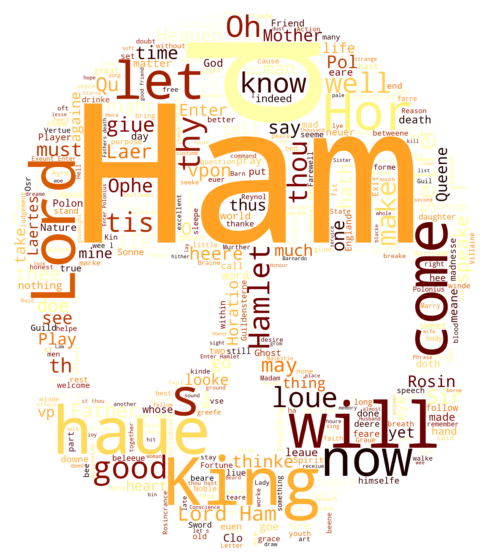

In [85]:
# Challenge: use the scull image to create a word cloud 
# for Shakespeare´s play Hamlet

hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)    # converts the image object to an array

wc = WordCloud(mask=rgb_array, background_color='white',
               max_words=400, colormap='afmhot')
wc.generate(hamlet_as_string)

plt.figure(figsize=[16,7])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

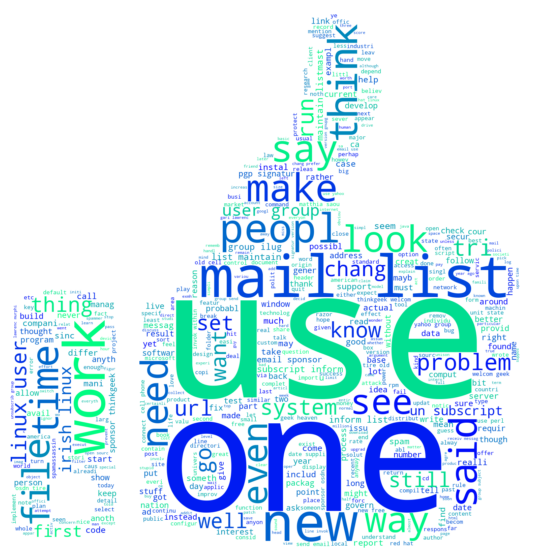

In [86]:
# Create word cloud of the Ham words
ham_icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=ham_icon.size, color=(255, 255, 255))
image_mask.paste(ham_icon, box=ham_icon)
rgb_array = np.array(image_mask)    # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

wc = WordCloud(mask=rgb_array, background_color='white',
               max_words=500, colormap='winter')
wc.generate(ham_str)

plt.figure(figsize=[16,7])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

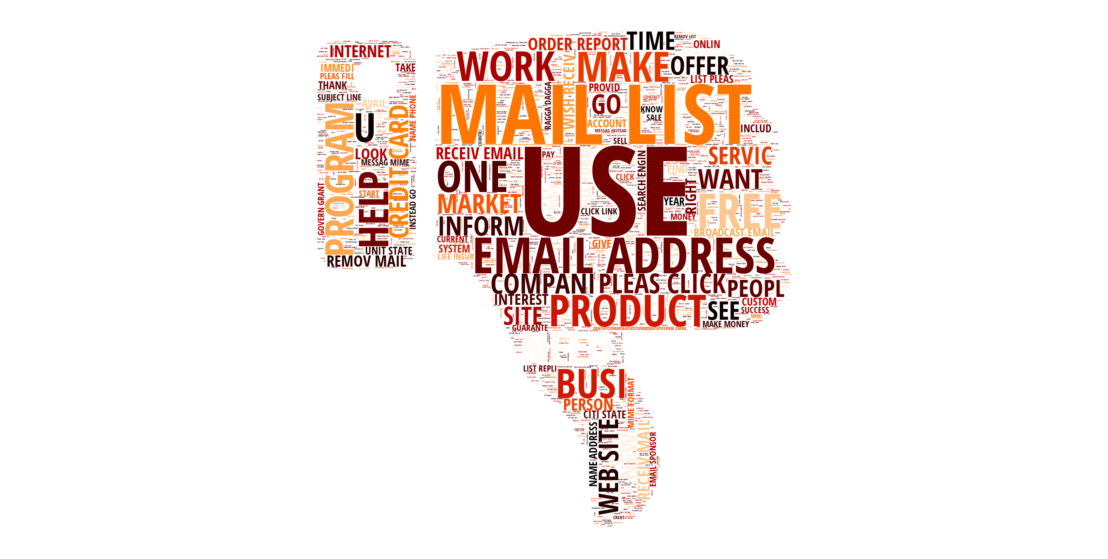

In [87]:
# Challenge: Use the custom font instead of the default and create word cloud of the spammy words
spam_icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=spam_icon.size, color=(255, 255, 255))
image_mask.paste(spam_icon, box=spam_icon)
rgb_array = np.array(image_mask)    # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

wc = WordCloud(mask=rgb_array, background_color='white', min_font_size=4, max_font_size=300,
               max_words=1500, colormap='gist_heat', font_path=FONT_BOLD_FILE)
wc.generate(spam_str.upper())

plt.figure(figsize=[16,7])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [123]:
# data = všetky záznamy: ham aj spam

stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
print(stemmed_nested_list)
# flat_stemmed_list = všetky záznamy: ham aj spam ale iba očistené správy
# flat = slová oddelené čiarkami
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

# print(flat_stemmed_list)

C:\Users\eavf\AppData\Local\Temp\ipykernel_50876\3159258238.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = bs(message, 'html.parser')
C:\Users\eavf\AppData\Local\Temp\ipykernel_50876\3159258238.py:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = bs(message, 'html.parser')


DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object


In [89]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr. of unique words: ', unique_words.shape[0])
unique_words

Nr. of unique words:  27334


http            10660
use              5019
list             4851
email            4367
get              4200
                ...  
zarzycki            1
canyon              1
wmv                 1
kasichainula        1
macarthi            1
Name: count, Length: 27334, dtype: int64

In [90]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2500 words out of the total. Print out top 10 words
# frequent_words = ham + spam
# frequent words sa budú hľadať na identifikovanie či je alebo nie je spam. VOCAB_SIZE je tých 2500 najčastejších slov

frequent_words = unique_words[0:VOCAB_SIZE]

print('Most common words : \n', frequent_words[:10])


Most common words : 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [91]:
word_ids = list(range(0, VOCAB_SIZE))

# vocab = ham + spam
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name='WORD_ID'
vocab

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get
...            ...
2495           bob
2496      occasion
2497        bullet
2498        steven
2499        analog

[2500 rows x 1 columns]

## Save the Vocabulary as a CSV File

In [92]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Excercise: Checking if a Word is Part of the Vocabulary

In [93]:
# Challenge: Write code that checks if a particular word is part
# of the vocabulary. Your code should return True if the word is in the vocabulary
# and false otherwise. Check words:
# machine
# learning
# fun
# learn
# data
# science
# app
# brewery

# Most inefective way
# vocab.VOCAB_WORD == 'machine'

any(vocab.VOCAB_WORD == 'app')   # ineficient


True

In [94]:
# Using python sets:

'machin' in set(vocab.VOCAB_WORD)    # better way


True

# Excercise: Find Email with the Most Number of Words

In [95]:
# Challenge: Print number of words in the longest email (after cleaning and stemming).
# Note the longest email position in the list of cleaned emails. Print out the stemmed 
# list of words in the longest email. Print the longest email from the data dataframe.

# after cleaning and stemming = stemmed_nested_list
# stemmed_nested_list - series, so, find longest 


# flatted - tokenized = vocab
# dataframe = data

stemmed_nested_list
print("Teraz tlačím type :")
print(type(stemmed_nested_list))

print("Teraz tlačím obsah stemmed_nested_list :")
print(stemmed_nested_list)

print("Teraz tlačím obsah data :")
print(data)


Teraz tlačím type :
<class 'pandas.core.series.Series'>
Teraz tlačím obsah stemmed_nested_list :
DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object
Teraz tlačím obsah data :
        CATEGORY                                            MESSAGE  \
DOC_ID                                                                
0              1  <!DOCTYPE HTML PUBLIC "-//W3C

In [96]:
stemmed_nested_list.shape

(5796,)

In [97]:
# Cez For loop
clean_email_lenghts = []
for sublist in stemmed_nested_list:
    clean_email_lenghts.append(len(sublist))


In [98]:
# Cez python list comprehension
clean_email_lenghts = [len(sublist) for sublist in stemmed_nested_list]
print(max(clean_email_lenghts))
print(clean_email_lenghts)

7671
[92, 56, 44, 206, 45, 161, 47, 162, 203, 44, 55, 23, 44, 74, 64, 235, 47, 208, 36, 56, 223, 192, 0, 93, 14, 208, 44, 18, 64, 95, 312, 56, 141, 72, 55, 1066, 48, 139, 2, 90, 78, 4, 47, 70, 44, 75, 38, 12, 38, 63, 47, 51, 71, 80, 25, 275, 36, 63, 19, 18, 14, 40, 57, 18, 77, 28, 102, 41, 226, 68, 120, 5, 52, 0, 40, 40, 208, 0, 40, 146, 62, 114, 64, 253, 1221, 49, 0, 65, 52, 145, 15, 0, 90, 70, 2, 198, 50, 50, 50, 214, 119, 43, 80, 44, 319, 243, 9, 36, 98, 26, 52, 333, 47, 42, 0, 38, 78, 97, 79, 55, 102, 34, 70, 55, 18, 129, 50, 0, 39, 74, 43, 72, 47, 80, 0, 28, 223, 97, 0, 58, 84, 214, 75, 47, 18, 104, 20, 114, 110, 187, 6, 40, 54, 79, 276, 110, 208, 6, 489, 62, 17, 175, 79, 47, 74, 82, 255, 33, 218, 38, 36, 110, 93, 61, 55, 41, 108, 80, 84, 0, 52, 1390, 108, 97, 25, 185, 1, 119, 255, 28, 137, 195, 177, 0, 98, 109, 1466, 0, 108, 150, 113, 38, 153, 38, 42, 0, 0, 383, 188, 77, 330, 14, 92, 92, 104, 372, 187, 241, 143, 254, 14, 98, 135, 223, 65, 90, 226, 217, 129, 38, 94, 204, 255, 215,

In [99]:
# Nájsť pozíciu emailu v liste

print('Email position in the list (and the dataframe): ', np.argmax(clean_email_lenghts))

Email position in the list (and the dataframe):  5775


In [100]:
stemmed_nested_list[5775]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [101]:
data.at[np.argmax(clean_email_lenghts), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix
## Creating a DataFrame with one Word per Column

In [102]:
print(type(stemmed_nested_list))
print(stemmed_nested_list)

<class 'pandas.core.series.Series'>
DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object


In [103]:
type(stemmed_nested_list[2])

list

In [104]:
# Ideme skonvertovať zo series obsahujúcich listy na listy obsahujúce listy
type(stemmed_nested_list.tolist())





list

In [105]:
stemmed_nested_list.tolist()

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [106]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

0      1       2      3           4         5       6     7       8     \
0     save   life   insur  spend        life      quot    save     g  famili   
1    fight   risk  cancer   http        slim  guarante    lose    lb     day   
2    fight   risk  cancer   http        slim  guarante    lose    lb     day   
3    adult   club   offer   free  membership   instant  access  site    user   
4  thought  might    like   slim    guarante      lose      lb   day    http   

      9     ...  7661  7662  7663  7664  7665  7666  7667  7668  7669  7670  
0  financi  ...  None  None  None  None  None  None  None  None  None  None  
1     http  ...  None  None  None  None  None  None  None  None  None  None  
2     http  ...  None  None  None  None  None  None  None  None  None  None  
3     name  ...  None  None  None  None  None  None  None  None  None  None  
4    fight  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 7671 columns]

In [107]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into Training and Testing Dataset

In [108]:
# Challenge: Can you split the data into a training and testing set? Test size 30 %.
# Training data should include4057 emails. Use a seed value of 42 to shuffle the data.
# What should the target values be?

# Rozdelíme dáta na učiace a testovacie v pomere 80:20 
X_train, X_test, y_train, y_test = ttsplit(word_columns_df, data.CATEGORY,
                                           test_size=0.3, random_state=42)


In [109]:
print('Nr. of training samples: ', X_train.shape[0])
print('Fraction of training set: ', X_train.shape[0] / word_columns_df.shape[0])

Nr. of training samples:  4057
Fraction of training set:  0.6999654934437544


In [110]:
X_train.index.name  = X_test.index.name = 'DOC_ID'
X_train.head()

0       1      2          3            4      5        6     \
DOC_ID                                                                   
4844         ye    inde  agent  directori       verita     cd     unix   
4727    problem    come    tri     instal  harddissssk   like  alreadi   
5022     origin  messag   date        mon          aug   chad  norwood   
3504      inlin    folk  sever      major     internet  outag     morn   
3921        url    http   date       bath     chronicl   None     None   

                7      8        9     ...  7661  7662  7663  7664  7665  7666  \
DOC_ID                                ...                                       
4844    subdirectori   file     call  ...  None  None  None  None  None  None   
4727           mount   http    yahoo  ...  None  None  None  None  None  None   
5022            sven     cc  subject  ...  None  None  None  None  None  None   
3504          across  major   provid  ...  None  None  None  None  None  None   
3921            None   None     None  ...  None  None  None  None  None  None   

        7667  7668  7669  7670  
DOC_ID                          
4844    None  None  None  None  
4727    None  None  None  None  
5022    None  None  None  None  
3504    None  None  None  None  
3921    None  None  None  None  

[5 rows x 7671 columns]

In [111]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [112]:
X_test.head()

0        1       2         3          4         5          6     \
DOC_ID                                                                        
4675    interest    alway  wonder     thing        bad    exampl       goto   
4220         url     http    date     final        gdc     europ     review   
2484     stephen  william  mailto  swilliam     weaken      food   transact   
2418          el      mon     sep  bitbitch      wrote     eugen       mani   
5110       music   school    joke  american  conductor  european  conductor   

             7         8             9     ...  7661  7662  7663  7664  7665  \
DOC_ID                                     ...                                 
4675      languag   support          goto  ...  None  None  None  None  None   
4220    confernec   session           ect  ...  None  None  None  None  None   
2484     argument      note  neighborhood  ...  None  None  None  None  None   
2418         homo    friend         lover  ...  None  None  None  None  None   
5110         talk  european     conductor  ...  None  None  None  None  None   

        7666  7667  7668  7669  7670  
DOC_ID                                
4675    None  None  None  None  None  
4220    None  None  None  None  None  
2484    None  None  None  None  None  
2418    None  None  None  None  None  
5110    None  None  None  None  None  

[5 rows x 7671 columns]

In [113]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

Na vytvorenie Sparse matrix použijeme 3 veci:
- X_train DataFrame
- y_train PD Series
- vocabulary words (2500) - vocab


In [114]:
# Vytvoríme index z VOCAB_WORD vo vocab
word_index = pd.Index(vocab.VOCAB_WORD)
print(type(word_index))
print(type(word_index[3]))

<class 'pandas.core.indexes.base.Index'>
<class 'str'>


In [115]:
# Ak chceme wedieť word ID pre slovo "thu" wo word indexe
word_index.get_loc('thu')

393

In [116]:
# word_index.get_loc('rodent') - pozor chyba, lebo slovo sa nedostalo do zoznamu frekv. slov

In [130]:
# Ako vytvoríme z X_train Sparse Matrix
"""
    X_train:'DOC_ID', '0','1','2', ...
             4844, thu, jul, rodent, ...
    Sparse Matrix: 'DOC_ID','WORD_ID','LABEL','OCCURENCE'
                    4844, 395, 0, 1
    Hľadáme 'thu' a je na 0 pozícii pre DOC_ID = 4844:
    X_train.index[0] => dostaneme z indexu X_train, je to prvá poloha
    y_train.at[4844] => label/ kategoria je v y_train, kde pre DOC_ID uložené či je to spam alebo nie (1/0)
    word_index.get_loc['thu'] => hľadáme 1. stem word ('thu') vnašom zozname frekventovaných prvých 2500 slov
"""

def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns Sparse Matrix as DataFrame.
    
    df: A dataframe with words in the columns with a document ID as an index (X_train or X_test)
    indexed_words: index of words ordered by word_ID
    labels: category as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                # Pozícia nášho slova v indexed_words
                word_id = indexed_words.get_loc(word)
                # spam alebo nie je spam
                category = labels.at[doc_id]
                # Dictionary for single item is:
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                # Zbierka dictionaries....
                dict_list.append(item)
    
    
    return pd.DataFrame(dict_list)
     


In [131]:
%%time
# Uložíme výslednú DF do:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)


CPU times: total: 6min 21s
Wall time: 6min 20s


In [132]:
sparse_train_df[:5]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    4844          1      265
1      0    4844          1     1243
2      0    4844          1      502
3      0    4844          1      308
4      0    4844          1      254

In [135]:
X_train.shape

(4057, 7671)

In [136]:
y_train

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
       ..
3772    0
5191    0
5226    0
5390    0
860     1
Name: CATEGORY, Length: 4057, dtype: int64

In [138]:
sparse_train_df.shape

(429241, 4)

In [140]:
sparse_train_df[-5:]

LABEL  DOC_ID  OCCURENCE  WORD_ID
429236      1     860          1       47
429237      1     860          1     1431
429238      1     860          1       26
429239      1     860          1       21
429240      1     860          1      126

### Combine Occurences with the Pandas groupby() Method

In [141]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [143]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [144]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [145]:
train_grouped = train_grouped.reset_index()
train_grouped


DOC_ID  WORD_ID  LABEL  OCCURENCE
0            0        2      1          1
1            0        3      1          2
2            0        4      1          1
3            0        7      1          3
4            0       11      1          1
...        ...      ...    ...        ...
258355    5795     2035      0          2
258356    5795     2040      0          1
258357    5795     2272      0          1
258358    5795     2342      0          1
258359    5795     2370      0          1

[258360 rows x 4 columns]

In [147]:
print(vocab.at[2035, 'VOCAB_WORD'])
print(data.MESSAGE[5795])

swap
Hi there,



Now this is probably of no use to you whatsoever, but...



Not a deb-head, but I also have a problem regards NVidia. I've two machines,

pretty much the same hardware. 

athlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,

both use the same driver module. 



Both have same kernel version albeit it compiled for their particular

hardware.



One works perfectly, the other fails to load. When I check with lsmod, I can

see the NVdriver is loaded, but not used ;--(

Thus when I startx, it bombs out. 



IU still have X with the default nv driver and crappy accelleration -->

650fps with glxgears [should be over 2000fps]

Its not a hardware issue with the cards as I swapped them over and get the

same symptoms. 



I reckon my mobo is cack, I've tried swapping slots around, reserving

resources etc all to no avail. 

Should there be an interrupt for the nv card? I haven't checked the other

box yet.



Regards,

CW



-------------------

On Tue, 03

In [148]:
train_grouped.shape

(258360, 4)

### Save Training Data as .txt File

In [151]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [152]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

Can you create a sparse matrix for the test data.
Group the occurences of the same word in the same email. Then save data as a .txt file.

In [155]:
%%time
# Uložíme výslednú DF do:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 2min 38s
Wall time: 2min 39s


In [159]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped

DOC_ID  WORD_ID  LABEL  OCCURENCE
0            8        2      1          1
1            8        3      1          4
2            8        4      1          2
3            8        5      1          1
4            8        6      1          2
...        ...      ...    ...        ...
117771    5793     2329      0          2
117772    5793     2353      0          1
117773    5793     2374      0          4
117774    5793     2403      0          3
117775    5793     2491      0          1

[117776 rows x 4 columns]

In [160]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [161]:
test_grouped.shape

(117776, 4)

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 
emails for testing.

How many individual emails were included in the testing .txt file? Count the number in the 
test_grouped DataFrame. After splitting and shuffling our data, how many emails were included 
in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why?
Compare the DOC_ID value to find out.

In [162]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [164]:
len(test_doc_ids)

1724

In [165]:
len(train_doc_ids)

4013

In [167]:
len(X_train)

4057

In [168]:
len(X_test)

1739

In [169]:
X_test.index
# Index sú vlastne documents ids

Index([4675, 4220, 2484, 2418, 5110, 1161, 3296,  101, 3337,  401,
       ...
       3674, 4885, 5120, 1338, 2671, 5295, 5740, 5069, 1293, 4354],
      dtype='int64', name='DOC_ID', length=1739)

In [171]:
set(X_test.index.values)

# Chceme zistiť, ktoré hodnoty chýbajú v tomto sete oproti test_doc_ids

{8,
 12,
 14,
 15,
 17,
 19,
 23,
 26,
 29,
 30,
 33,
 37,
 43,
 44,
 45,
 47,
 51,
 61,
 62,
 63,
 65,
 68,
 69,
 70,
 71,
 75,
 79,
 80,
 84,
 88,
 90,
 93,
 95,
 96,
 99,
 100,
 101,
 102,
 106,
 107,
 109,
 110,
 120,
 121,
 122,
 124,
 132,
 134,
 135,
 139,
 142,
 144,
 149,
 150,
 151,
 156,
 157,
 167,
 168,
 175,
 177,
 179,
 181,
 183,
 184,
 185,
 192,
 195,
 196,
 199,
 203,
 208,
 210,
 214,
 217,
 218,
 219,
 221,
 227,
 228,
 229,
 230,
 233,
 238,
 239,
 240,
 245,
 247,
 248,
 251,
 252,
 254,
 257,
 259,
 263,
 272,
 274,
 279,
 283,
 286,
 287,
 290,
 291,
 292,
 293,
 295,
 296,
 297,
 298,
 300,
 308,
 315,
 318,
 319,
 322,
 324,
 325,
 332,
 333,
 334,
 336,
 339,
 346,
 350,
 351,
 354,
 360,
 366,
 367,
 371,
 373,
 376,
 378,
 380,
 381,
 387,
 393,
 401,
 408,
 410,
 411,
 414,
 415,
 416,
 418,
 422,
 425,
 426,
 428,
 429,
 437,
 438,
 439,
 443,
 445,
 447,
 450,
 451,
 452,
 453,
 457,
 463,
 465,
 468,
 471,
 472,
 473,
 478,
 479,
 485,
 486,
 491,
 497

In [173]:
# Takže jednoduchý rozdiel medzi 2 setmi
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [196]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG

In [198]:
data.MESSAGE[240]

'------=_NextPart_000_00B6_07E34C7A.C3030C43\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nSU1QT1JUQU5UIElORk9STUFUSU9OOg0KDQpUaGUgbmV3IGRvbWFpbiBuYW1l\n\ncyBhcmUgZmluYWxseSBhdmFpbGFibGUgdG8gdGhlIGdlbmVyYWwgcHVibGlj\n\nIGF0IGRpc2NvdW50IHByaWNlcy4gTm93IHlvdSBjYW4gcmVnaXN0ZXIgb25l\n\nIG9mIHRoZSBleGNpdGluZyBuZXcgLkJJWiBvciAuSU5GTyBkb21haW4gbmFt\n\nZXMsIGFzIHdlbGwgYXMgdGhlIG9yaWdpbmFsIC5DT00gYW5kIC5ORVQgbmFt\n\nZXMgZm9yIGp1c3QgJDE0Ljk1LiBUaGVzZSBicmFuZCBuZXcgZG9tYWluIGV4\n\ndGVuc2lvbnMgd2VyZSByZWNlbnRseSBhcHByb3ZlZCBieSBJQ0FOTiBhbmQg\n\naGF2ZSB0aGUgc2FtZSByaWdodHMgYXMgdGhlIG9yaWdpbmFsIC5DT00gYW5k\n\nIC5ORVQgZG9tYWluIG5hbWVzLiBUaGUgYmlnZ2VzdCBiZW5lZml0IGlzIG9m\n\nLWNvdXJzZSB0aGF0IHRoZSAuQklaIGFuZCAuSU5GTyBkb21haW4gbmFtZXMg\n\nYXJlIGN1cnJlbnRseSBtb3JlIGF2YWlsYWJsZS4gaS5lLiBpdCB3aWxsIGJl\n\nIG11Y2ggZWFzaWVyIHRvIHJlZ2lzdGVyIGFuIGF0dHJhY3RpdmUgYW5kIGVh\n\nc3ktdG8tcmVtZW1iZXIgZG9tYWluIG5hbWUgZm9yIHRoZSBzYW1lIHByaWNl\n\nLiAgVmlzaXQ6IGh0dHA6Ly93d

In [176]:
data.loc[240]

CATEGORY                                                     1
MESSAGE      ------=_NextPart_000_00B6_07E34C7A.C3030C43\n\...
FILE_NAME               00241.c28ade5771085a8fddd054a219566b7c
Name: 240, dtype: object

In [179]:
clean_message_no_html(data.at[274, 'MESSAGE'])

['dqorkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr',
 'kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrdqpuaglzigvtywl',
 'kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']

In [209]:
data.MESSAGE[734]

'<html>\n\n<body bgcolor="#7CB5F0">\n\n<a href="http://teens.xxxfreehosting.com/hotteens/index.html"><img border="0" src="http://members.aol.com/tjoyce/mail_01.gif" width="500" height="558" border=0></a><br>\n\n<a href="mailto:flojo@btamail.net.cn"><img border="0" src="http://members.aol.com/tjoyce/mail_02.gif" width="500" height="42" border=0>\n\n</a>\n\n</body>\n\n</html>\n\n4623\n\n\n\n\n'

In [211]:
clean_message_no_html(data.at[734, 'MESSAGE'])

[]

In [212]:
# Beautiful soup vymazal všetko z mailu, bolo tam veľa html oproti textu
clean_message(data.at[734, 'MESSAGE'])

['html', 'bodi', 'http', 'img', 'http', 'br', 'mailto', 'flojo', 'img', 'http']